訓練集: 2940, 驗證集: 630, 測試集: 630
使用裝置: cuda
Epoch 1/10 - Loss: 0.3167 - Val Loss: 0.1440 - Val Acc: 0.9905
Epoch 2/10 - Loss: 0.0968 - Val Loss: 0.0469 - Val Acc: 0.9937
Epoch 3/10 - Loss: 0.0463 - Val Loss: 0.0314 - Val Acc: 0.9968
Epoch 4/10 - Loss: 0.0279 - Val Loss: 0.0225 - Val Acc: 1.0000
Epoch 5/10 - Loss: 0.0270 - Val Loss: 0.0178 - Val Acc: 1.0000
Epoch 6/10 - Loss: 0.0166 - Val Loss: 0.0095 - Val Acc: 0.9984
Epoch 7/10 - Loss: 0.0098 - Val Loss: 0.0076 - Val Acc: 0.9984
Epoch 8/10 - Loss: 0.0099 - Val Loss: 0.0060 - Val Acc: 1.0000
Epoch 9/10 - Loss: 0.0073 - Val Loss: 0.0033 - Val Acc: 1.0000
Epoch 10/10 - Loss: 0.0051 - Val Loss: 0.0042 - Val Acc: 1.0000


C:\Users\lun\AppData\Local\Temp\ipykernel_29008\1589258159.py:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       525
          TB       1.00      0.99      1.00       105

    accuracy                           1.00       630
   macro avg       1.00      1.00      1.00       630
weighted avg       1.00      1.00      1.00       630



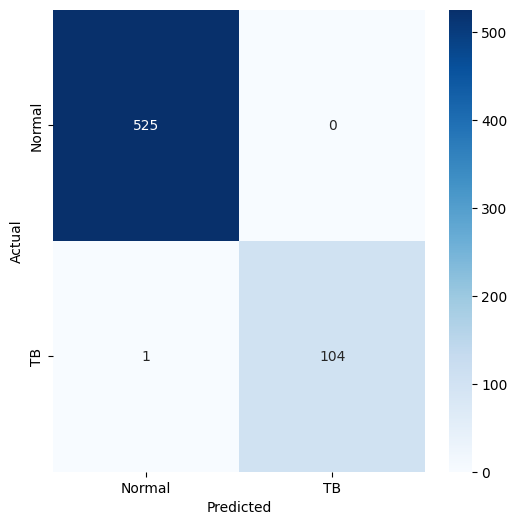

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 資料讀取與切割
# ==========================================
data_dir = "./TB_Chest"  # 本地端資料夾路徑
all_filepaths = []
all_labels = []

classes = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
class_to_idx = {cls: i for i, cls in enumerate(classes)} # {'Normal': 0, 'Tuberculosis': 1}

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    files = os.listdir(class_path)
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_filepaths.append(os.path.join(class_path, file))
            all_labels.append(class_to_idx[class_name])

full_df = pd.DataFrame({'filepaths': all_filepaths, 'labels': all_labels})

# 切割比例 70/15/15
train_df, temp_df = train_test_split(full_df, train_size=0.7, shuffle=True, random_state=42, stratify=full_df['labels'])
valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=42, stratify=temp_df['labels'])

print(f"訓練集: {len(train_df)}, 驗證集: {len(valid_df)}, 測試集: {len(test_df)}")

# ==========================================
# 2. 自定義 Dataset 與 Transform
# ==========================================
class TBChestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepaths']
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['labels']
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

img_size = (256, 256)
train_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = TBChestDataset(train_df, transform=train_transform)
valid_dataset = TBChestDataset(valid_df, transform=val_test_transform)
test_dataset  = TBChestDataset(test_df, transform=val_test_transform)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ==========================================
# 3. 建立 ResNet50 模型
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用裝置: {device}")

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# 凍結前段權重 (如同原 Notebook 的 Fine-tuning 策略)
for param in model.parameters():
    param.requires_grad = True # 先設為 True

# 模擬原代碼：凍結到特定層 (ResNet50 約 170 層，143 層後開始訓練)
child_counter = 0
for child in model.children():
    if child_counter < 7: # 凍結前 7 個模組
        for param in child.parameters():
            param.requires_grad = False
    child_counter += 1

# 修改最後輸出層
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1),
    nn.Sigmoid()
)
model = model.to(device)

# 計算 Class Weight (針對不平衡樣本)
weights = compute_class_weight('balanced', classes=np.unique(train_df['labels']), y=train_df['labels'])
pos_weight = torch.tensor([weights[1] / weights[0]]).to(device)

criterion = nn.BCELoss() # 因為最後用了 Sigmoid
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# ==========================================
# 4. 訓練迴圈
# ==========================================
epochs = 10
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).view(-1, 1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    
    # 驗證
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device).view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    val_loss /= len(valid_loader.dataset)
    val_acc = correct / len(valid_loader.dataset)
    
    print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

# ==========================================
# 5. 測試集評估
# ==========================================
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float().cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=['Normal', 'TB']))

# 混淆矩陣
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'TB'], yticklabels=['Normal', 'TB'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()